## File: onet_task_adjacency.ipynb
#### Summary: Explores ONET data to motivate th Agentic AI model

#### By: Peyman Shahidi
#### Created: Jan 15, 2025

In [113]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [114]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

placebo_analysis = True

In [115]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code Starts Here

<br>

## Section (1)

In [116]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# keep occupation, task, work activity, and detailed work activity columns
onet = onet[['occ_code', 'occ_title', 'task_id', 'task', 'wa_id', 'wa_name', 'dwa_id', 'dwa_title']]
onet = onet.sort_values(by=['occ_code', 'task_id', 'wa_id', 'dwa_id']).reset_index(drop=True)

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

### Remove "Teachers"-related occupations

In [117]:
# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

In [118]:
# Variables to work with
task_variable = 'dwa_title'
occupation_variable = 'occ_title'

# Remove duplicates in terms of occupation-task pairs
onet = onet.drop_duplicates(subset=[occupation_variable, task_variable])

# Other data cleanins
onet.replace("NaN", np.nan, inplace=True)
onet.dropna(how='any', inplace=True)

In [119]:
onet = onet[['occ_code', occupation_variable, task_variable]]

In [120]:
# Read datasets
cooccurrence_matrix = pd.read_csv(f'{output_data_path}/task_task_cooccurrence_matrix.csv')
task_scores_df = pd.read_csv(f'{output_data_path}/indiv_task_cooccurrence_scores.csv')
occupation_scores_df = pd.read_csv(f'{output_data_path}/indiv_occupation_cooccurrence_scores.csv')
pair_counts_df = pd.read_csv(f'{output_data_path}/task_pair_counts.csv')
occupation_overlap_df = pd.read_csv(f'{output_data_path}/occupation_similarity_matrix.csv')
weighted_pairs_df = pd.read_csv(f'{output_data_path}/task_pair_weightedScores.csv')
truncated_pair_counts = pd.read_csv(f'{output_data_path}/task_pair_weightedScores_truncated.csv')

## Get list of occupations and tasks in "truncated weighted scores" dataset with frequency of repetition

#### Occupations

In [121]:
from collections import Counter

# Step 1: Ensure entries in "Occupations_List" are actual Python lists
truncated_pair_counts['Occupations_List'] = truncated_pair_counts['Occupations_List'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

# Step 2: Flatten all occupations into a single list
all_occupations = [occupation for sublist in truncated_pair_counts['Occupations_List'] for occupation in sublist]

# Step 3: Count the occurrences of each unique occupation
occupation_counts = Counter(all_occupations)

# Step 4: Convert the results to a DataFrame for better visualization
unique_occupations_df = pd.DataFrame(occupation_counts.items(), columns=['Occupation', 'Count'])
unique_occupations_df = unique_occupations_df[unique_occupations_df.Count > 5]

# Step 5: Sort by count in descending order
unique_occupations_df = unique_occupations_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Save the results to a CSV file
unique_occupations_df.to_csv(f'{output_data_path}/cooccurring_tasks_occupation_dist.csv', index=False)

#### Tasks

In [122]:
# Step 1: Combine all tasks from both columns into a single list
all_tasks = truncated_pair_counts['Task1'].tolist() + truncated_pair_counts['Task2'].tolist()

# Step 2: Count the occurrences of each unique task
task_counts = Counter(all_tasks)

# Step 3: Convert the results to a DataFrame for better visualization
unique_tasks_df = pd.DataFrame(task_counts.items(), columns=['Task', 'Count'])

# Sort by count in descending order
unique_tasks_df = unique_tasks_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Save the results to a CSV file
unique_tasks_df.to_csv(f'{output_data_path}/cooccurring_tasks_task_dist.csv', index=False)

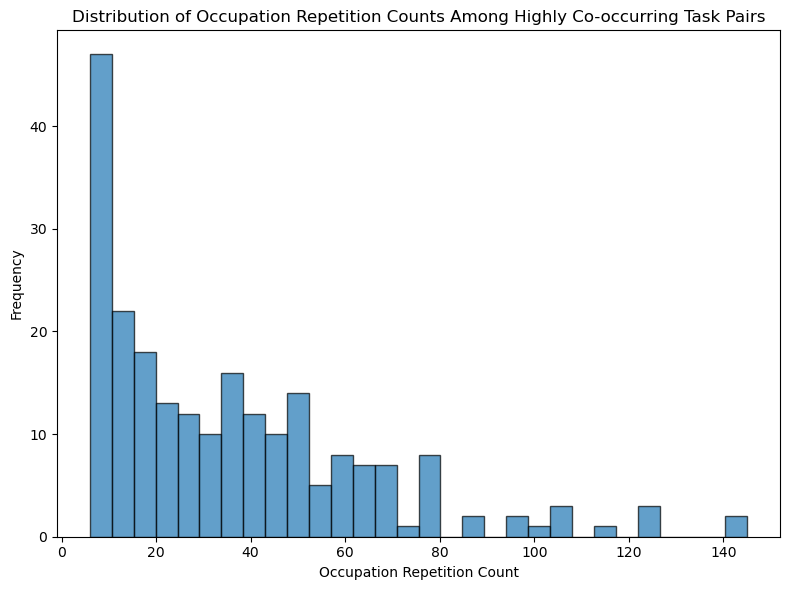

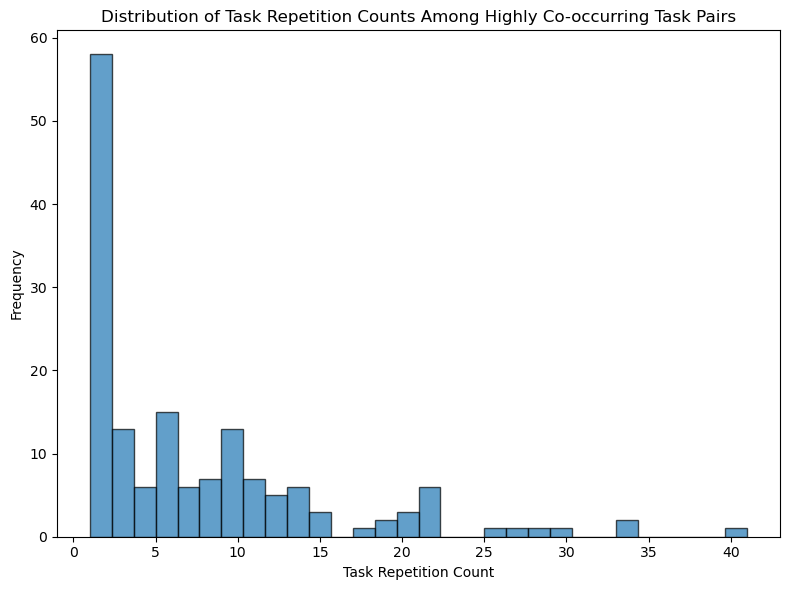

In [123]:
# Plot occupations
plt.figure(figsize=(8, 6))
plt.hist(unique_occupations_df['Count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Occupation Repetition Counts Among Highly Co-occurring Task Pairs')
plt.xlabel('Occupation Repetition Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{output_plot_path}/highly_cooccurring_tasks_occupation_repetition_count.png')
plt.show()

# Plot tasks
plt.figure(figsize=(8, 6))
plt.hist(unique_tasks_df['Count'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Task Repetition Counts Among Highly Co-occurring Task Pairs')
plt.xlabel('Task Repetition Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{output_plot_path}/highly_cooccurring_tasks_task_repetition_count.png')
plt.show()

## Analysis: See what fraction of each occupation is comprised of co-occurring tasks

In [124]:
# Get list of tasks
unique_tasks_list = unique_tasks_df['Task'].tolist()
print(f'Number of unique highly co-occurring tasks: {len(unique_tasks_list)}')

Number of unique highly co-occurring tasks: 158


In [125]:
# Step 1: Extract the first two characters of "occ_code" to define groups
onet['occ_group'] = onet['occ_code'].str[:2]

# Step 2: Group by "occ_group" and collect unique tasks for each group
unique_tasks_by_group = onet.groupby('occ_group')[task_variable].apply(lambda x: set(x)).reset_index()
unique_tasks_by_group.columns = ['occ_group', 'unique_tasks']

# Step 3: Calculate the intersection with "unique_tasks_list"
group_tasks_dict = {
    group: list(tasks.intersection(unique_tasks_list))
    for group, tasks in unique_tasks_by_group.set_index('occ_group')['unique_tasks'].items()
}

# Step 4: Calculate tasks in "unique_tasks_list" but not in the intersection for each group
outside_group_tasks_dict = {
    group: list(set(unique_tasks_list) - set(group_tasks_dict[group]))
    for group in group_tasks_dict
}

In [126]:
# Create a variable in ONET data to indicate if a task is co-occurring or not, based on co-occurring tasks both inside and outside the group
onet['inside_group_cooccurring_task'] = onet.apply(
    lambda row: 1 if row[task_variable] in group_tasks_dict[row['occ_group']] else 0,
    axis=1
)

onet['outside_group_cooccurring_task'] = onet.apply(
    lambda row: 1 if row[task_variable] in outside_group_tasks_dict[row['occ_group']] else 0,
    axis=1
)

# Calculate the average of "cooccurring_task" within occupation groups
onet['fraction_tasks_cooccurring_inside'] = onet.groupby(['occ_code', occupation_variable])['inside_group_cooccurring_task'].transform('mean')
onet['fraction_tasks_cooccurring_outside'] = onet.groupby(['occ_code', occupation_variable])['outside_group_cooccurring_task'].transform('mean')

# Create a new DataFrame with occupation and average co-occurring task
fraction_tasks_cooccurring_df = onet[['occ_code', occupation_variable, 'fraction_tasks_cooccurring_inside', 'fraction_tasks_cooccurring_outside']].drop_duplicates()
fraction_tasks_cooccurring_df = fraction_tasks_cooccurring_df.sort_values(by='fraction_tasks_cooccurring_inside', ascending=False).reset_index(drop=True)

# Merge with task count data
tasks_per_occupation = onet.groupby(occupation_variable)[task_variable].size().reset_index(name='task_count')
fraction_tasks_cooccurring_df = fraction_tasks_cooccurring_df.merge(tasks_per_occupation, on=occupation_variable)
fraction_tasks_cooccurring_df

,occ_code,occ_title,fraction_tasks_cooccurring_inside,fraction_tasks_cooccurring_outside,task_count
0,29-1213,Dermatologists,0.93,0.00,14
1,51-8031,Water and Wastewater Treatment Plant and Syste...,0.91,0.00,11
2,51-6042,Shoe Machine Operators and Tenders,0.88,0.00,16
3,29-1217,Neurologists,0.87,0.00,23
4,51-9192,"Cleaning, Washing, and Metal Pickling Equipmen...",0.87,0.00,15
...,...,...,...,...,...
743,27-3043,Writers and Authors,0.00,0.00,17
744,27-3042,Technical Writers,0.00,0.00,12
745,27-3041,Editors,0.00,0.00,14
746,27-3031,Public Relations Specialists,0.00,0.00,11


#### Merge SOC groups to 2 digit ONET occupation codes

In [127]:
# Merge SOC groups to 2 digit codes
fraction_tasks_cooccurring_df['occ_group'] = fraction_tasks_cooccurring_df['occ_code'].str[:2]

# Read SOC groups and derive 2 digit codes (from https://www.onetcenter.org/taxonomy/2019/structure.html)
soc_group = pd.read_csv(f'{input_data_path}/SOC_Structure.csv')
soc_group = soc_group[['Major Group', 'SOC or O*NET-SOC 2019 Title']]
soc_group = soc_group.rename(columns={'SOC or O*NET-SOC 2019 Title': 'occ_group_title', 'Major Group': 'occ_group'})

# Prepare dataset for the merge
soc_group = soc_group.dropna()
soc_group['occ_group_title'] = soc_group['occ_group_title'].str[:-12]
soc_group['occ_group_title'] = soc_group['occ_group_title'].str[:50]
soc_group['occ_group'] = soc_group['occ_group'].str[:2]

# Merge datasets
fraction_tasks_cooccurring_df = pd.merge(fraction_tasks_cooccurring_df, soc_group, how='left')
fraction_tasks_cooccurring_df = fraction_tasks_cooccurring_df[['occ_group', 'occ_group_title', 'occ_code', occupation_variable, 'fraction_tasks_cooccurring_inside', 'fraction_tasks_cooccurring_outside', 'task_count']]

# Save the results to a CSV file
fraction_tasks_cooccurring_df.to_csv(f'{output_data_path}/fraction_tasks_cooccurring_by_occupation.csv', index=False)
fraction_tasks_cooccurring_df

,occ_group,occ_group_title,occ_code,occ_title,fraction_tasks_cooccurring_inside,fraction_tasks_cooccurring_outside,task_count
0,29,Healthcare Practitioners and Technical,29-1213,Dermatologists,0.93,0.00,14
1,51,Production,51-8031,Water and Wastewater Treatment Plant and Syste...,0.91,0.00,11
2,51,Production,51-6042,Shoe Machine Operators and Tenders,0.88,0.00,16
3,29,Healthcare Practitioners and Technical,29-1217,Neurologists,0.87,0.00,23
4,51,Production,51-9192,"Cleaning, Washing, and Metal Pickling Equipmen...",0.87,0.00,15
...,...,...,...,...,...,...,...
743,27,"Arts, Design, Entertainment, Sports, and Media",27-3043,Writers and Authors,0.00,0.00,17
744,27,"Arts, Design, Entertainment, Sports, and Media",27-3042,Technical Writers,0.00,0.00,12
745,27,"Arts, Design, Entertainment, Sports, and Media",27-3041,Editors,0.00,0.00,14
746,27,"Arts, Design, Entertainment, Sports, and Media",27-3031,Public Relations Specialists,0.00,0.00,11


In [128]:
# Step 1: Normalize the measure by number of tasks in each group
fraction_tasks_cooccurring_df['normalized_fraction_tasks_cooccurring_inside'] = fraction_tasks_cooccurring_df['fraction_tasks_cooccurring_inside'] / fraction_tasks_cooccurring_df['task_count']

# Step 2: Calculate the average "fraction_tasks_cooccurring" for each group
group_avg = fraction_tasks_cooccurring_df.groupby('occ_group_title')['normalized_fraction_tasks_cooccurring_inside'].mean()
group_avg = group_avg.sort_values(ascending=False)

# Step 3: Count the number of observations in each group
group_counts = fraction_tasks_cooccurring_df['occ_group_title'].value_counts()

# Step 4: Combine the two series into a single DataFrame
combined_df = pd.DataFrame({
    'occ_group_title': group_avg.index,
    'avg_normalized_fraction_tasks_cooccurring_inside': group_avg.values,
    'observation_count': group_counts.loc[group_avg.index].values
})

# Normalize the measure by number of tasks in each group
combined_df['normalized_avg'] = combined_df['avg_normalized_fraction_tasks_cooccurring_inside']
combined_df = combined_df.sort_values(by='normalized_avg', ascending=False).reset_index(drop=True)

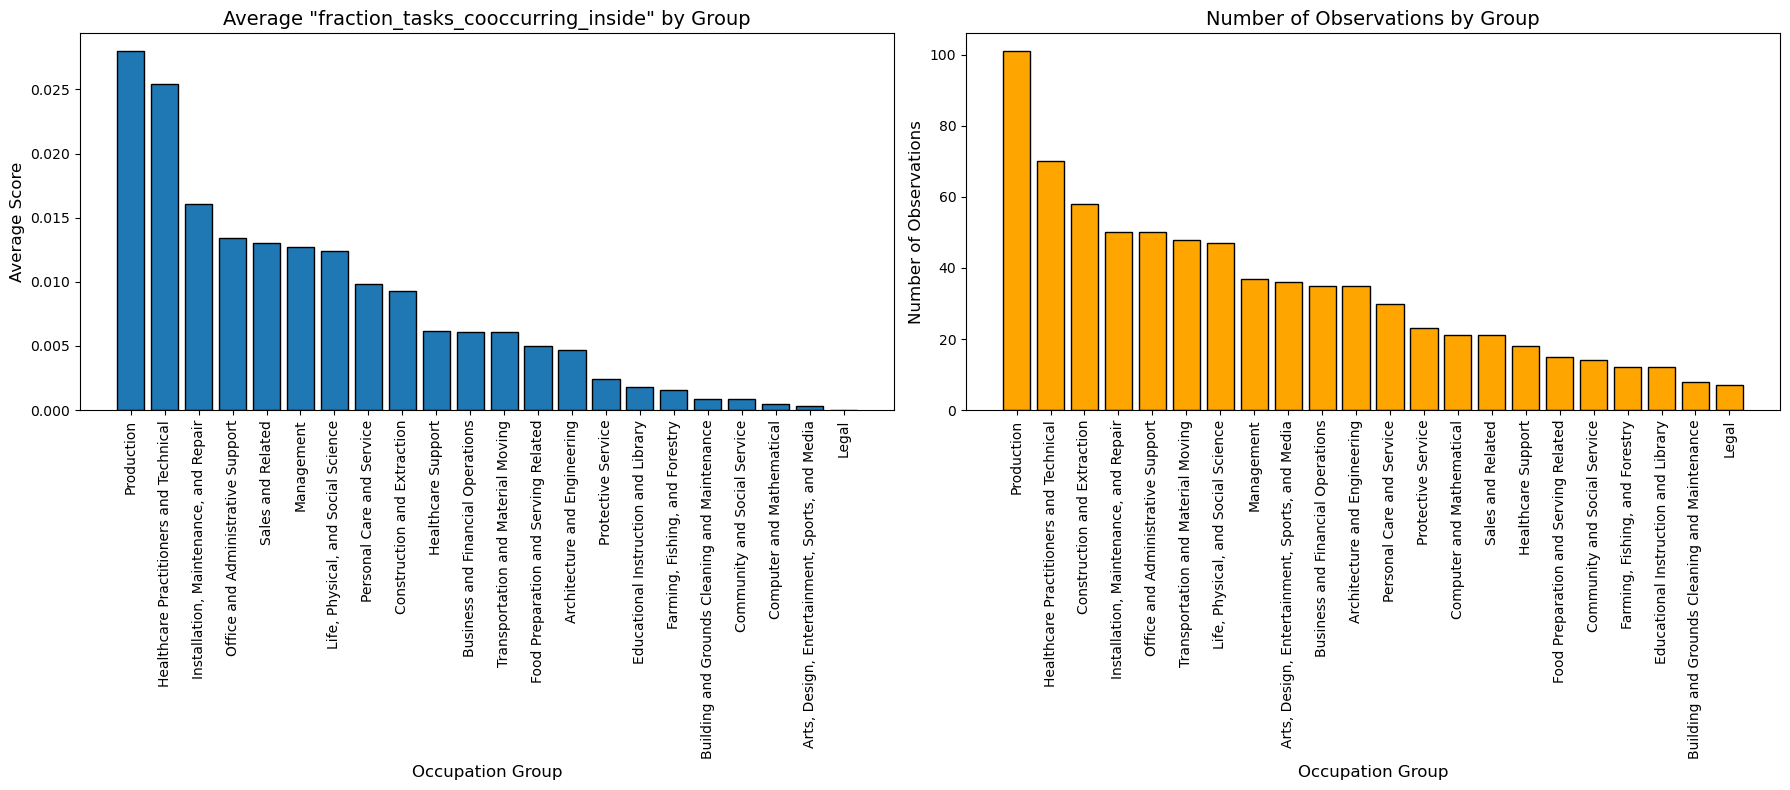

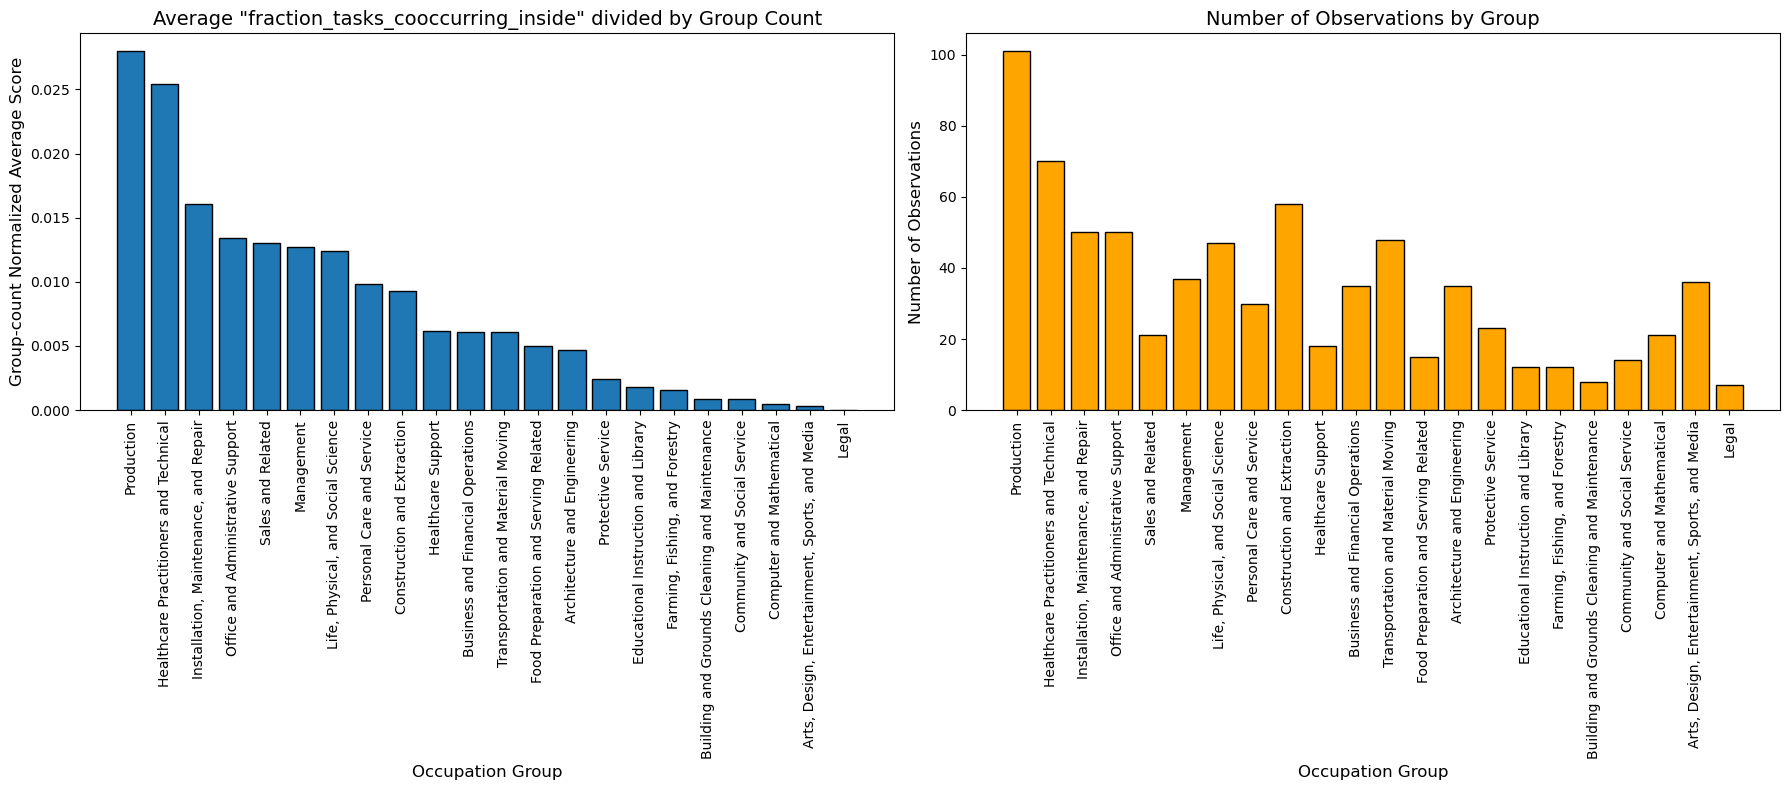

In [129]:
# Plot the raw average histogram
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Histogram of average "fraction_tasks_cooccurring_inside" by group
axes[0].bar(group_avg.index, group_avg.values, edgecolor='black')
axes[0].set_title('Average "fraction_tasks_cooccurring_inside" by Group', fontsize=14)
axes[0].set_xlabel('Occupation Group', fontsize=12)
axes[0].set_ylabel('Average Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Histogram of number of observations by group
axes[1].bar(group_counts.index, group_counts.values, color='orange', edgecolor='black')
axes[1].set_title('Number of Observations by Group', fontsize=14)
axes[1].set_xlabel('Occupation Group', fontsize=12)
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig(f'{output_plot_path}/fraction_cooccurring_task_raw.png', dpi=300)
plt.show()


# Plot the group-count normalized average histogram
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Histogram of average "fraction_tasks_cooccurring_inside" by group
axes[0].bar(combined_df.occ_group_title, combined_df.normalized_avg, edgecolor='black')
axes[0].set_title('Average "fraction_tasks_cooccurring_inside" divided by Group Count', fontsize=14)
axes[0].set_xlabel('Occupation Group', fontsize=12)
axes[0].set_ylabel('Group-count Normalized Average Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Histogram of number of observations by group
axes[1].bar(combined_df.occ_group_title, combined_df.observation_count, color='orange', edgecolor='black')
axes[1].set_title('Number of Observations by Group', fontsize=14)
axes[1].set_xlabel('Occupation Group', fontsize=12)
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig(f'{output_plot_path}/fraction_cooccurring_task_normalized.png', dpi=300)
plt.show()

In [130]:
# Get list of tasks
unique_tasks_list = unique_tasks_df['Task'].tolist()
print(f'Number of unique co-occurring tasks: {len(unique_tasks_list)}')

Number of unique co-occurring tasks: 158


In [131]:
# Step 1: Extract the first two characters of "occ_code" to define groups
onet['occ_group'] = onet['occ_code'].str[:2]

# Step 2: Group by "occ_group" and collect unique tasks for each group
unique_tasks_by_group = onet.groupby('occ_group')[task_variable].apply(lambda x: set(x)).reset_index()
unique_tasks_by_group.columns = ['occ_group', 'unique_tasks']

# Step 3: Calculate the intersection with "unique_tasks_list"
group_tasks_dict = {
    group: list(tasks.intersection(unique_tasks_list))
    for group, tasks in unique_tasks_by_group.set_index('occ_group')['unique_tasks'].items()
}

# Step 4: Calculate tasks in "unique_tasks_list" but not in the intersection for each group
outside_group_tasks_dict = {
    group: list(set(unique_tasks_list) - set(group_tasks_dict[group]))
    for group in group_tasks_dict
}

In [132]:
# Create a variable in ONET data to indicate if a task is co-occurring or not, based on co-occurring tasks outside the group
onet['cooccurring_task'] = onet.apply(
    lambda row: 1 if row[task_variable] in outside_group_tasks_dict[row['occ_group']] else 0,
    axis=1
)

# Calculate the average of "cooccurring_task" within occupation groups
onet['fraction_tasks_cooccurring'] = onet.groupby(['occ_code', occupation_variable])['cooccurring_task'].transform('mean')

# Create a new DataFrame with occupation and average co-occurring task
fraction_tasks_cooccurring_df = onet[['occ_code', occupation_variable, 'fraction_tasks_cooccurring']].drop_duplicates()
fraction_tasks_cooccurring_df = fraction_tasks_cooccurring_df.sort_values(by='fraction_tasks_cooccurring', ascending=False).reset_index(drop=True)
fraction_tasks_cooccurring_df

,occ_code,occ_title,fraction_tasks_cooccurring
0,11-1011,Chief Executives,0.00
1,47-2061,Construction Laborers,0.00
2,47-2021,Brickmasons and Blockmasons,0.00
3,47-2022,Stonemasons,0.00
4,47-2031,Carpenters,0.00
...,...,...,...
743,29-1051,Pharmacists,0.00
744,29-1071,Physician Assistants,0.00
745,29-1081,Podiatrists,0.00
746,29-1122,Occupational Therapists,0.00


### Check common tasks (not necessarily co-occurring) between occupation groups

In [133]:
# Step 1: Extract the first two characters of "occ_code" to define groups
onet['occ_group'] = onet['occ_code'].str[:2]

# Step 2: Group by "occ_group" and collect unique tasks for each group
unique_tasks_by_group = onet.groupby('occ_group')[task_variable].apply(lambda x: set(x)).reset_index()
unique_tasks_by_group.columns = ['occ_group', 'unique_tasks']

# Step 3: Create a dictionary for easy lookup
unique_tasks_by_group_dict = unique_tasks_by_group.set_index('occ_group')['unique_tasks'].to_dict()

# Step 4: Initialize an empty DataFrame for the pairwise matrix
occ_groups = list(unique_tasks_by_group_dict.keys())
matrix = pd.DataFrame(0, index=occ_groups, columns=occ_groups)

# Step 5: Calculate the number of common tasks for each pair of occupation groups
for group1 in occ_groups:
    for group2 in occ_groups:
        common_tasks = unique_tasks_by_group_dict[group1].intersection(unique_tasks_by_group_dict[group2])
        matrix.loc[group1, group2] = len(common_tasks)

# Step 6: Rename columns
# Create a dictionary from soc_group DataFrame
occ_group_dict = pd.Series(soc_group['occ_group_title'].values, index=soc_group['occ_group']).to_dict()

# Substitute the row and column labels using the dictionary
matrix.rename(index=occ_group_dict, columns=occ_group_dict, inplace=True)

matrix.to_csv(f'{output_data_path}/occupation_group_task_overlap_count.csv', index=True)

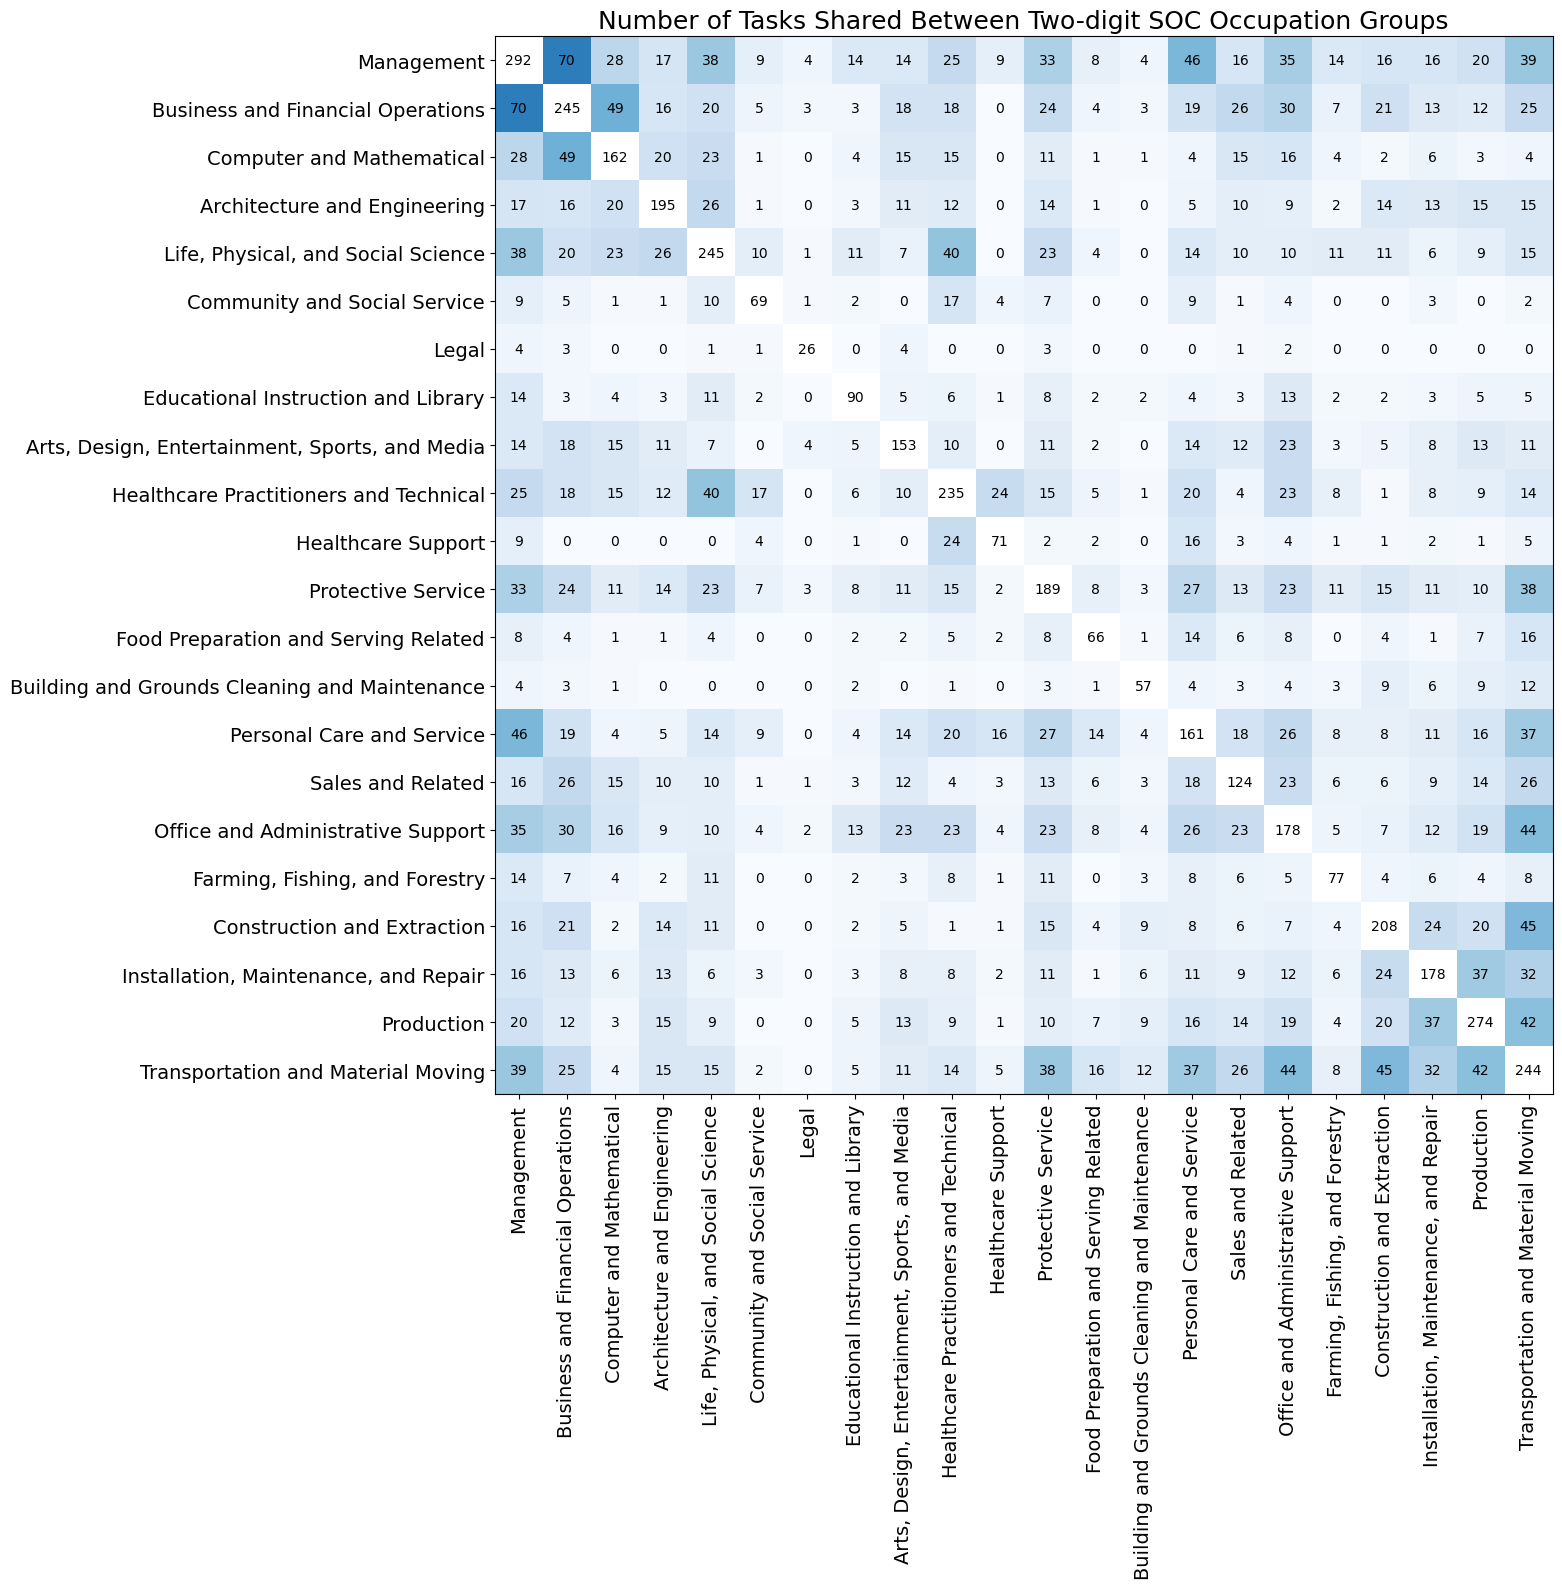

In [162]:
from matplotlib.colors import LinearSegmentedColormap

# Set the diagonal elements to NaN (this will ensure no color for the diagonal)
matrix_with_nan_diag = matrix.where(~np.eye(matrix.shape[0], dtype=bool))

# To save the heatmap as an image with integer numbers, we plot it
plt.figure(figsize=(16, 16))
cax = plt.imshow(matrix_with_nan_diag, cmap='Blues', interpolation='nearest', vmin=0, vmax=100)

# Drop the color bar
plt.colorbar(cax).remove()

# Adding integer numbers to the cells, skipping diagonal elements
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, f'{matrix.iloc[i, j]}', ha='center', va='center', color='black')

# Set the labels for rows and columns
plt.xticks(ticks=np.arange(matrix.shape[1]), labels=matrix.columns, rotation=90, fontsize=14)
plt.yticks(ticks=np.arange(matrix.shape[0]), labels=matrix.index, fontsize=14)

plt.title("Number of Tasks Shared Between Two-digit SOC Occupation Groups", fontsize=18)
plt.tight_layout()

# Save the heatmap as an image
plt.savefig(f'{output_plot_path}/occupation_group_common_tasks_heatmap.png', dpi=300)
plt.show()